In [10]:
!pip install -qqq -r requirements.txt

# Domino Reference Project - Anomaly Detection

This is a reference Domino Project adapted from the Kaggle dataset and notebook found [here](https://www.kaggle.com/code/leomauro/anomaly-detection-streaming-data/input)
This notebook presents a few unsupervised algorithms to detect anomaly in CPU Utilization streaming data. We are going to experiment Anomaly Detection in [Numenta Anomaly Benchmark (NAB)](https://www.kaggle.com/boltzmannbrain/nab). 

> **Summary** - Build and track algorithms to detect anomalies in CPU Utilization streaming data


We will apply 3 algorithms to our data:
1. Moving Average
2. Exponential Moving Average
3. Isolation Forest


-----
<a id="data"></a>
# Data Exploration

We are using data from the [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB/blob/master/data/) which presents a corpus of 58 timeseries data files, designed to provide data for research in streaming anomaly detection. Let's inspect our CPU Utilization data

In [175]:
import numpy as np
import pandas as pd
import datetime as dt
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

### CPU Utilization

<Axes: >

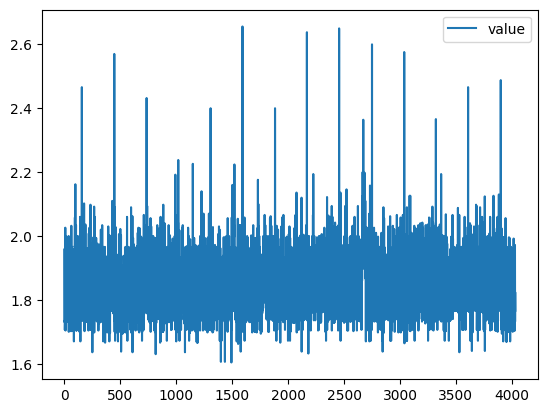

In [176]:
cpu = pd.read_csv(
    "https://raw.githubusercontent.com/numenta/NAB/master/data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv"
)
cpu.plot()

-----
<a id="anomaly"></a>
# Streaming Anomaly Detection

Do you want to monitor your computer metrics and detect anomalies in your existing streaming data? We are going to see a few algorithms for that:

- Streaming Moving Average
- Streaming Exponential Average

## Plot Function

In [177]:
def plot_anomalies(
    data: pd.DataFrame, model, model_name: str, predict_batch: bool = False
):
    """Plot the Streaming Data (an Anomalies)"""
    df = data.copy()
    # create a subplot
    fig, axes = plt.subplots()
    fig.suptitle(f"Anomaly Detection - {model_name}")

    get_timestamp = lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timestamp()
    df["timestamp"] = df.timestamp.apply(get_timestamp)
    X = df.timestamp
    Y = df.value

    # predict anomalies
    if predict_batch:
        preds = model.predict(df)
        averages = None
        stds = None
    else:
        preds = [model.predict(i, v) for i, v in zip(X, Y)]
        preds, averages, stds = tuple(zip(*preds))

    # plot the results
    results_df = pd.DataFrame(data={"x": X, "value": Y, "pred": preds})
    if averages is not None and stds is not None:
        results_df["avg"] = averages
        results_df["std"] = stds
        results_df["ymin"] = results_df["value"] - results_df["std"]
        results_df["ymax"] = results_df["value"] + results_df["std"]
    size = results_df.pred.astype(int) * 20
    sns.lineplot(ax=axes, data=results_df, x="x", y="value")
    sns.scatterplot(ax=axes, data=results_df, x="x", y="value", hue="pred", size=size)

    if averages is not None:
        axes.fill_between(
            results_df.x, results_df.avg, results_df.ymax, facecolor="green", alpha=0.2
        )
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()

## Moving Average

**Moving Average** is the most common type of average used in Time Series problems. We perform the sum of recent data points and divide them by the time period. Further, we simple check if the new record is far from the expected value. The expected value range is computed using the formula `Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report as an anomaly.

In [178]:
class StreamingMovingAverage:
    """Moving Average algorithm"""

    def __init__(self, threshold=1.5) -> None:
        self.threshold = threshold
        self.min_nof_records_in_model = 3
        self.window_size = 3 * self.min_nof_records_in_model
        self.data_streaming = []
        self.previous_timestamp = 0

    def _update_state(self, timestamp: int, value: float) -> None:
        """Update the model state"""
        self.previous_timestamp = timestamp
        self.data_streaming.append(value)
        # Keep a consistent window
        if len(self.data_streaming) > self.window_size:
            self.data_streaming.pop(0)

    @property
    def model_name(self) -> str:
        return f"Moving Average Threshold {self.threshold}"

    @property
    def enough_data(self) -> bool:
        """Check if there is enough data"""
        return len(self.data_streaming) >= self.min_nof_records_in_model

    def _expected_value(self, timestamp: int) -> float:
        """Return the expected value"""
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        many = self.min_nof_records_in_model
        return data.rolling(many, min_periods=1).mean().iloc[-1]

    def _standard_deviation(self) -> float:
        """Return the standard deviation"""
        data = self.data_streaming
        return np.std(data, axis=0)

    def predict(self, timestamp: int, value: float) -> tuple[bool, float, float]:
        self._update_state(timestamp, value)
        expected_value = self._expected_value(timestamp)
        # is there enough data and is not NaN value
        anomaly, curr_value, deviation = False, value, 0.0
        if self.enough_data and not np.isnan(expected_value):
            curr_value = expected_value
            deviation = self._standard_deviation() * self.threshold
            if expected_value + deviation < value:
                anomaly = True
        return anomaly, curr_value, deviation

Detect anomalies with a threshold of 2 standard deviations

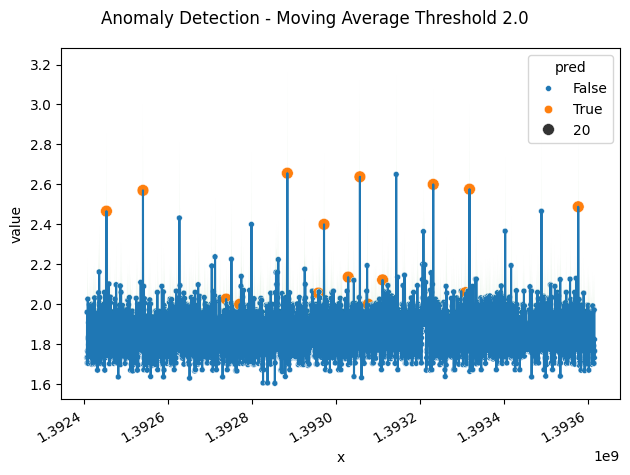

In [179]:
model = StreamingMovingAverage(threshold=2.0)
plot_anomalies(cpu, model, model.model_name)

We'll find more anomalies with a standard deviation of 1.0 (higher recall), but we'll have more false positives (lower precision)

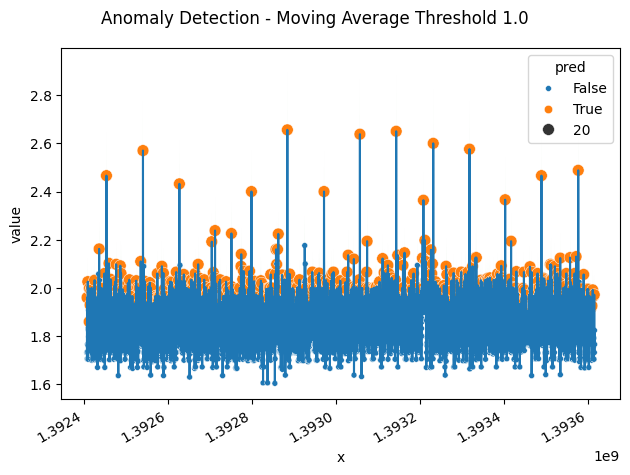

In [180]:
model = StreamingMovingAverage(threshold=1.0)
plot_anomalies(cpu, model, model.model_name)

Let's zoom in on a sample of traffic data.

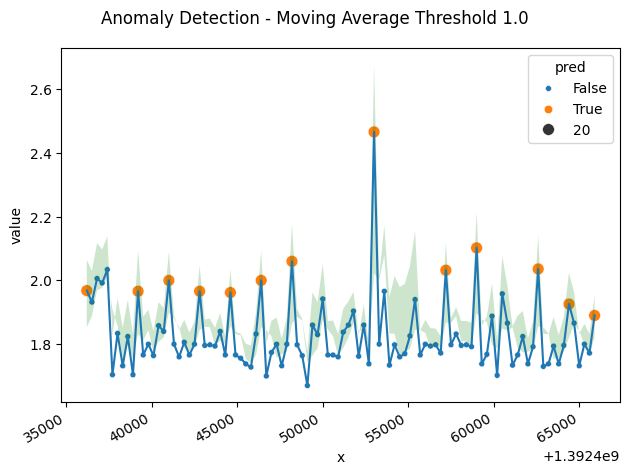

In [181]:
sample = cpu.iloc[100:200]
plot_anomalies(sample, model, model.model_name)

## Results

We can see that the Moving Average is not smoothing the expected values as well as we'd like.

## Exponential Moving Average

**Exponential Moving Average** weighs more recently seen values more heavily; ie, they are weighted by timestamp. The expected value range is computed using the formula `Exponential Moving Average + standard deviation * threshold`; if it is out of the expected value range, we report an anomaly.

Exponential Moving Average requires a parameter `alpha` which determines the importance of the previous record. The alpha parameter defines the smoothing that the average applies to the time series. Alpha is a constant smoothing factor that ranges from 0 to 1. A higher alpha discounts older data faster, placing greater relevance on more current data. 

The formula for alpha is: `alpha = 2 / (N + 1)`

In [182]:
class StreamingExponentialMovingAverage(StreamingMovingAverage):
    """Exponential Weighted Moving Average (EWMA) algorithm"""

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.ewm.html

    def __init__(self, threshold=1.5, alpha=0.3) -> None:
        super().__init__(threshold)
        self.alpha = alpha

    @property
    def model_name(self) -> str:
        return super().model_name + f" alpha {self.alpha}"

    @property
    def enough_data(self) -> bool:
        """Check if there is enough data"""
        return len(self.data_streaming) > 0

    def _expected_value(self, timestamp: int) -> float:
        """Return the expected value"""
        data = self.data_streaming
        data = pd.Series(data=data, dtype=float)
        return data.ewm(alpha=self.alpha, adjust=True).mean().iloc[-1]

Let's try to reproduce the Moving Average anomalies in Travel Time dataset.

- In this case, we found the parameters `threshold=1.5` and `alpha=0.5`

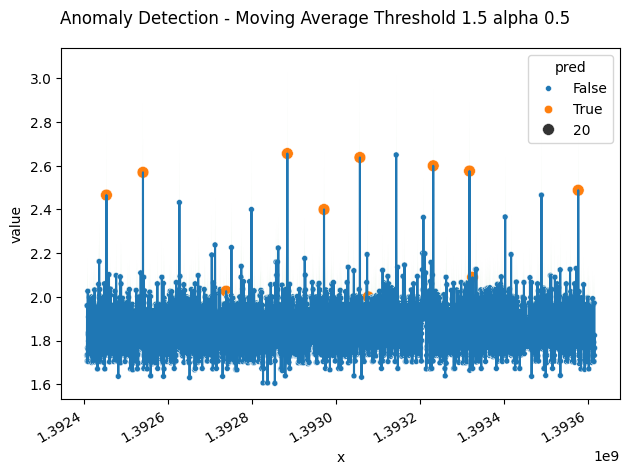

In [183]:
model = StreamingExponentialMovingAverage(threshold=1.5, alpha=0.5)
plot_anomalies(cpu, model, model.model_name)

Comparing _Moving Average_ with _Exponential Moving Average_, we can noticed that Exponential smoothes the expected value and avoids detecting unnecessary outliers.

You can tune alpha to see how large of an effect it has!

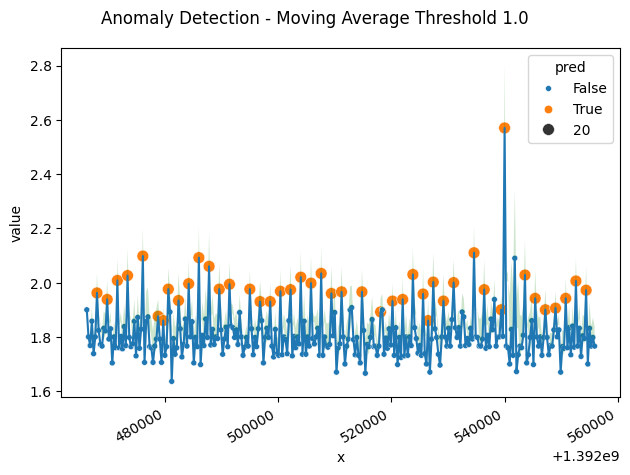

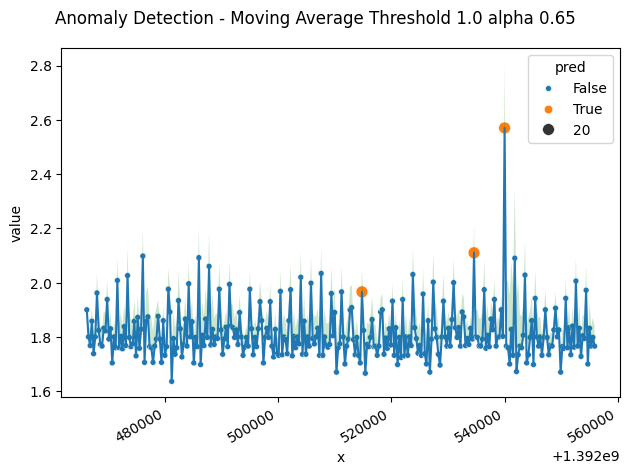

In [184]:
sample = cpu.iloc[200:500]

ma_model = StreamingMovingAverage(threshold=1.0)
plot_anomalies(sample, ma_model, ma_model.model_name)

ema_model = StreamingExponentialMovingAverage(threshold=1.0, alpha=0.65)
plot_anomalies(sample, ema_model, ema_model.model_name)

# Can we improve further?

Moving Average and Exponential Moving Average are straightforward approaches to anomaly detection, but can we use more sophisticated approaches?

## Isolation Forest

The Isolation Forest algorithm, designed for anomaly detection, constructs a random forest where clusters of points are isolated into individual samples through random partitioning. Anomalies, being rare and different, are quickly isolated as they require fewer partitions to stand apart from regular data points. By measuring the average number of partitions across all trees, anomalies are scored based on their swift isolation, making them distinct from normal points which usually require deeper partitions. 

This method is efficient and scalable, making it ideal for large datasets and high-dimensional data. In essence, the Isolation Forest identifies anomalies by capitalizing on their unique and sparse nature within the dataset.

With a non-anomalous point, you can see that many "slices" are required to isolate it
![alt text](./images/Isolating_a_Non-Anomalous_Point.png)<br>
Isolationg a non-anomalous point. <a href="https://commons.wikimedia.org/wiki/File:Isolating_a_Non-Anomalous_Point.png">Sal Borrelli</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons
<br>

On the other hand, an anomalous point can quickly be identified<br>

![alt text](./images/Isolating_an_Anomalous_Point.png)<br>
Isolationg an anomalous point.<a href="https://commons.wikimedia.org/wiki/File:Isolating_an_Anomalous_Point.png">Sal Borrelli</a>, <a href="https://creativecommons.org/licenses/by-sa/4.0">CC BY-SA 4.0</a>, via Wikimedia Commons

## Training

The IsolationForest algorithm takes 1 parameter, `contamination`, which specifies what percentage of the dataset contains anomalies. Based on our original plot, we can identiy ~15 anomalies. Feel free to tweak this to your liking!

**Important:** By its nature, Isolation Forests don't have sense of time. They independently classify points based on their separability. To address this, we consider time another feature in the dataset, and we pass the pair (timestamp, value) to the isolation forest. IsolationForest models are very robust to data of across many dimensions, so handling 2 simultaneously is very straightforward. This also means that if you have more than 2 data points (such as other metadata about the CPU, such as what programs are being run), you could include those (just ensure you normalize the data).

In [194]:
from sklearn.ensemble import IsolationForest

# 15 total anomalies
total_anomalies = 15
contamination = total_anomalies / len(cpu)

model = IsolationForest(contamination=contamination, random_state=42)

df = cpu.copy()
get_timestamp = lambda x: dt.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timestamp()
df["timestamp"] = df.timestamp.apply(get_timestamp)

X_train = df.values

model.fit(X_train)

IsolationForest(contamination=0.003720238095238095, random_state=42)

In [197]:
# Isolation Forest returns -1 for anomaly, and 1 for not-anomaly. We want to map it to our plot function,
# so we map those to False for not anomaly, and True for anomaly
class MappedIsoModel:
    def __init__(self, model: IsolationForest):
        self.model = model

    def predict(self, df: pd.DataFrame) -> np.ndarray:
        """Predict and map to plotting values. -1 should be True, 1 False"""
        preds = self.model.predict(df.values)
        preds = np.array([True if p == -1 else False for p in preds])
        return preds

    @property
    def model_name(self):
        return f"Isolation Forest contamination {self.model.contamination}"


mapped_model = MappedIsoModel(model)

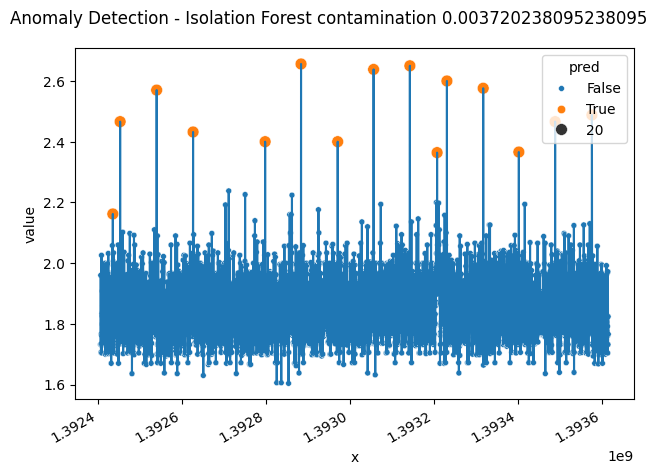

In [198]:
plot_anomalies(cpu, mapped_model, mapped_model.model_name, predict_batch=True)

In [ ]:
algorithm = StreamingExponentialMovingAverage
parameters = {"threshold": 1.5, "alpha": 0.5}
title = ["CPU Utilization", "Network Usage", "Travel Time", "Twitter Volume"]
plot_anomalies([cpu, network, traffic, twitter], algorithm, parameters, title)

Unfortunatelly, this algorithms presented a lot of anomalies in Twitter Volume data. This is happening because the volume decrease and increase quicklly - causing this confusion in the algorithm. What can we do?
- We can raise the `threshold`, to increase limit for the anomalies; or
- We can raise the `threshold` and decrease the `alpha`, to increase the smoothness

In [ ]:
algorithm = StreamingExponentialMovingAverage
parameters = {"threshold": 1.6, "alpha": 0.5}
title = ["Twitter Volume"]
plot_anomalies([twitter], algorithm, parameters, title)

In [ ]:
algorithm = StreamingExponentialMovingAverage
parameters = {"threshold": 1.8, "alpha": 0.4}
title = ["Twitter Volume"]
plot_anomalies([twitter], algorithm, parameters, title)